#Tutorial 5: Deep Learning

**By Guillermo Martin**

Hi everyone, welcome back! Today we will cover what is arguably the most popular machine learning ensemble.

Note: The computational power and RAM required for this tutorial are significantly higher than in previous tutorials. We recommend that you run this notebook on your computer instead of Colab.

##Index
*   Neural Networks
*   Keras and TensorFlow
*   Malaria TensorFlow Database
*   Convolutional Neural Networks
*   Transfer Learning and ResNets


##Neural Networks
A neural network (NN) is a model consisting on a set of neurons divided into **layers** and connected from layer to layer. The way they work loosely resembles how our brain processes information.

If a neural network contains many layers, we call it a **deep** neural network. We will first use a sklearn neural network model (multilayer perceptron classifier) and then Keras, a TensorFlow API, for our diabetes dataset.

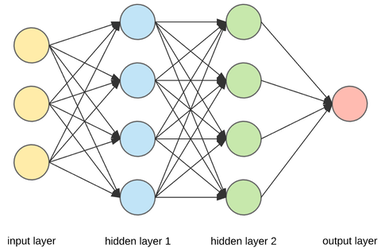

###How neural  networks process information
(#pointer to more information and learning/backpropagation info)

Each connection between neurons $i, j$ of adjacent layers has a corresponding weight $w_{ij}$ and each neuron $i$ has a bias $b_i$.

The output of a neuron is calculated by individually multiplying the outputs of each neuron of the previous layer by the weights associated to the connection of the neuron, and then adding the resulting numbers. Finally, a number associated to the neuron, called the bias,  is added into the result and a nonlinear function $f$ (which we call an "activation" function) is applied. Usually we apply ReLU or sigmoid functions, **ReLU** being the prefered choice as networks with ReLUs are faster and converge quicker (though sometimes we might use sigmoid too, see later).

In classification tasks, given some training data, neural networks can be trained with backpropagation. Do check http://neuralnetworksanddeeplearning.com/chap2.html if you want to learn more about this process.

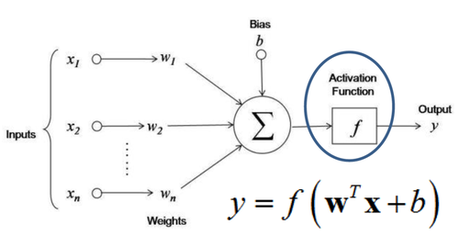

Nonlinear activation functions help the neural network capture nonlinearities in the data. That is something that many models aren't able to do and is one of the reasons why they are so useful!

Lets review our PIMA indians diabetes database:

In [ ]:
import pandas as pd
#import dataset from url, which is in CSV format (comma-separated values)
column_names = ["pregnancies", "glucose", "bloodp", "skinthick", "insulin", "bmi", "diabetespedi", "age", "label"]
#we use column_names as parameter for names so that we can easily choose which columns we want later on
dataset = pd.read_csv(r"https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv", names=column_names, skiprows=1)
print("Samples (rows):", dataset.shape[0], ", features (columns):", dataset.shape[1])
dataset.head()

Samples (rows): 768 , features (columns): 9


,pregnancies,glucose,bloodp,skinthick,insulin,bmi,diabetespedi,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
#split dataset into the diagnostic measurement and label (target) variable
#we can easily do it with the column names that we previously defined
#and with .label indexing method
measures = ["pregnancies", "glucose", "bloodp", "skinthick", "insulin", "bmi", "diabetespedi", "age"]
X = dataset[measures]
y = dataset.label
#this will help us divide our dataset into training and testing datasets:
from sklearn.model_selection import train_test_split
#randomly split dataset into training and testing datasets
#30% of the dataset will be testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

###Sklearn MLPClassifier (multilayer perceptron classifier)
Now we are going to use a new sklearn model, a MLPClassifier, which really is a neural network.

In [ ]:
from sklearn.neural_network import MLPClassifier
neuralnet = MLPClassifier()
neuralnet.fit(X_train, y_train)

MLPClassifier()

Note we are not adding any parameters to our model, this is just an example.

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = neuralnet.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7316017316017316


Remember from tutorial 3 that accuracy was not the best metric for this problem. False negatives are more worrying than false positives! Let's use recall, which tells us how well we classify the true infected samples.
Recall that, $$\text{recall} = \frac{TP}{TP+FN}$$

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.3150684931506849

Our model does not do that well! Let's do some hyperparameter selection:

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = {
    "hidden_layer_sizes": [(10, 50, 10), (100, 100), (100,), (1000,)],
    "activation": ["logistic", "relu"],
    "solver": ["sgd", "adam"],
    "learning_rate": ["constant","adaptive"],
     "max_iter": [500, 1000]
}
gridsearch = GridSearchCV(MLPClassifier(), grid ,cv=10) #k=10
gridsearch.fit(X_train, y_train)

Phew, that took a long while to compute!

Note that in sklearn, neural networks have the same activation functions for all layers, which is not ideal in this case. Ideally, we would want ReLU in every layer but the last one, where we would want a sigmoid activation function as it gives us a value between 0 and 1, which gives the output in a nice probabilistic form.

In [ ]:
gridsearch.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (1000,),
 'learning_rate': 'constant',
 'max_iter': 1000,
 'solver': 'adam'}

The sigmoid activation function performs better in this case, as we would expect since having ReLUs in our last layer would not help us to get an output in probabilistic form. However, networks with sigmoid activation function take significantly longer to be trained.

In [ ]:
best_nn =  gridsearch.best_estimator_
y_pred_nn = best_nn.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred_nn))
print("recall:", recall_score(y_test, y_pred_nn))

accuracy: 0.7835497835497836
recall: 0.589041095890411


A bit better, but there is still a lot of room for improvement! The flexibility of Keras will help us with this.

##Keras and TensorFlow
For simple neural networks with few layers, sklearn worked just fine. However, in practice many neural networks are way more complex than that, with hundreds of layers and more complicated structures.

Keras is a Deep Learning library that allows us to manage this complexity effectively, which in turn is a TensorFlow API (with allows us to do numerical linear algebra in GPUs).

Note we could also use Pytorch, which is faster but object-oriented and harder to learn.

In [ ]:
import tensorflow as tf
#Sequential allows us to create a NN by specifying the layers sequentially
from tensorflow.keras.models import Sequential
#Dense implements the function that makes each neuron work
from tensorflow.keras.layers import Dense

We build our model using **Sequential**, where we sequentially stack a group of layers together as follows:

In [ ]:
#initialize the model
nn = Sequential()
#input layer has 8 neurons, one for each diagnostic measurement
nn.add(Dense(12, input_shape=(8,), activation="relu")) #hidden layer 1, with 12 neurons
nn.add(Dense(8, activation="relu")) #hidden layer 2, with 8 neurons
nn.add(Dense(1, activation="sigmoid")) #output layer, with 1 neuron (scalar binary output)

Dense layers are just the regular "densely"-connected layers that we saw before.

Now we compile our model.

In [ ]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Recall()])

We use binary cross entropy as our loss function, which in this case is more suitable than accuracy, and optimize (i.e. train) our model with ADAM.

We could train our model by using all of our training data to compute our loss function and then update our parameters. However, that is very computationally expensive. An alternative is to divide our training data into batches and compute our loss funcion on each of them and update the parameters sequentially. An epoch is when we have run through all the batches, and thus all of our training data.

Note that in the past, neural networks used to be trained with stochastic gradient descent by propagation, but there are now better algorithms like **ADAM**.

In [ ]:
nn.fit(X_train, y_train, epochs=100, batch_size=150)

In [ ]:
loss, accuracy, recall = nn.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
print("Recall:", recall)

8/8 [==============================] - 0s 3ms/step - loss: 0.6046 - accuracy: 0.6970 - recall: 0.5890
Accuracy: 0.6969696879386902
Recall: 0.5890411138534546


We get a better recall! This model performs better than our sklearn MLP one, due to the flexibility allowed by Keras.

##Malaria TensorFlow Database
For the first time in these tutorials, we will switch to another database: the Malaria TensorFlow Database. This consists of 27,558 samples of images of segmented cells. Half of them are parasitized (0) and half of them uninfected (1), so the data is balanced.

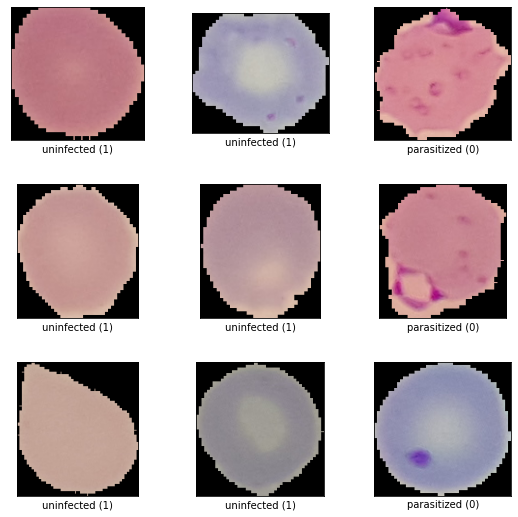

In [ ]:
import tensorflow_datasets as tfds
ds, ds_info = tfds.load("malaria", split="train", with_info=True)
#with split="train" all samples are selected
visualize = tfds.visualization.show_examples(ds, ds_info)

We split the dataset so that 75% is training data and 25% is testing data. Note we could also use a validation set, but we won't for simplicity.

In [ ]:
train, test = tfds.load("malaria", split=["train[:75%]", "train[75%:]"],
                              as_supervised=True)

##Convolutional Neural Networks
For image processsing, we could flatten our image input into an array and use an ordinary (feedforward) neural network. However this is not optimal. We can use convolutional layers, which allows us to perform feature extraction (see the following image). After applying convolutional layers to our image input, we flatten the output into an array and feed that into a normal feedforward neural network which will then perform classification.

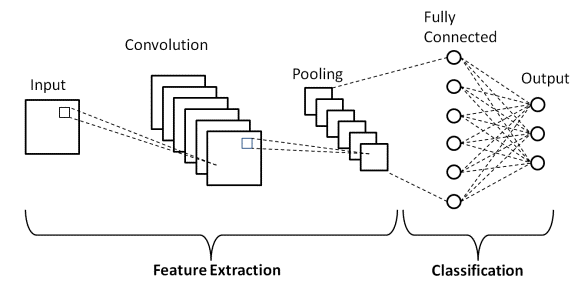

###Image preprocessing
The images of this dataset come in different sizes, so we have to resize them so that they are 200x200x3, with either cropping or padding:

In [ ]:
def process(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) #converts the image into a dtype, a numpy tensor ("multidimensional array")
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

Now we apply our process function to each element of the train data, with .cache() and .map():

In [ ]:
processed_train = train.cache().map(process).batch(64) #cache().map to process all images simulatenously

We will use 2D convolution and max pooling as our convolutional layers. If you want to learn more about how convolutional neural networks  work, you can check https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53 and https://keras.io/api/layers/

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Activation #convolutional layers

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    #flatten the output
    tf.keras.layers.Flatten(),
    #input it to a dense (normal connected neural network)
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #output of the NN (0-1)
]
)
#we use this convolutional setup because it works for feature extraction
#usually we choose the best architecture with some trial and error
#based on architectures that have worked for other similar problems

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model.fit(processed_train, batch_size=64, epochs=10)

###Model evaluation
First we preprocess the testing data:

In [ ]:
processed_test = test.cache().map(process).batch(32)

In [ ]:
model.evaluate(processed_test)

216/216 [==============================] - 2s 7ms/step - loss: 0.3009 - accuracy: 0.9492 - recall_1: 0.9680


[0.3008500039577484, 0.949201762676239, 0.9679953455924988]

It does very well, with very high recall! We can check a blueprint of our model with:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)      

##Transfer Learning and ResNets
The performance of our model is already quite good, but we can do better!

First of all, note that deep neural networks may take a long time to train - sometimes days or even weeks.
One thing we can do to speed up training is to reuse already-trained models with different - but hopefully similar - datasets. This is called transfer learning.

A trained model we are going to use is ResNet50 which is a residual network that has been pre-trained on the imagenet database (https://www.image-net.org/). A residual network consists of a normal neural network with some skip connections, which is a connection that skips some of the layers as seen at the right of the following image:

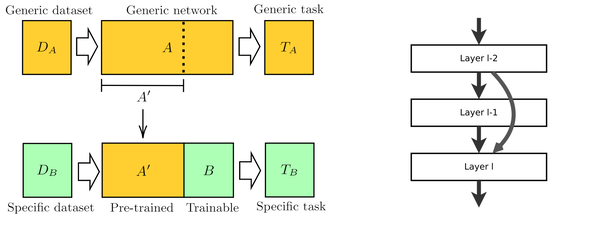

Due to the skip connections, if there are layers that are not very useful, or if there are too many layers that could cause overfitting, the skip connections will allow the network to "skip" them when processing the input, increasing its performance. That is what makes them one of the most popular architectures nowadays.

Note that in practice we may decide to "freeze" some of the layers of the pre-trained model (usually all but the last layers), forbidding the training algorithm to modify them, and thus speeding up training, though we won't do it in this case.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
#we dont include the top (last layer) of ResNet as otherwise the shape of our
#input would have to be the same as for ResNet!
resnet_model=ResNet50(weights='imagenet',include_top=False,input_shape=(200,200,3))
model=Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model.fit(processed_train, batch_size=64, epochs=10)

Epoch 1/10
323/323 [==============================] - 36s 92ms/step - loss: 0.8232 - accuracy: 0.9331 - recall_2: 0.9429
Epoch 2/10
323/323 [==============================] - 29s 91ms/step - loss: 0.1049 - accuracy: 0.9643 - recall_2: 0.9747
Epoch 3/10
323/323 [==============================] - 29s 91ms/step - loss: 0.0883 - accuracy: 0.9691 - recall_2: 0.9780
Epoch 4/10
323/323 [==============================] - 29s 91ms/step - loss: 0.0847 - accuracy: 0.9704 - recall_2: 0.9780
Epoch 5/10
323/323 [==============================] - 29s 91ms/step - loss: 0.0783 - accuracy: 0.9720 - recall_2: 0.9774
Epoch 6/10
323/323 [==============================] - 29s 90ms/step - loss: 0.0664 - accuracy: 0.9761 - recall_2: 0.9818
Epoch 7/10
323/323 [==============================] - 29s 91ms/step - loss: 0.0644 - accuracy: 0.9779 - recall_2: 0.9812
Epoch 8/10
323/323 [==============================] - 29s 91ms/step - loss: 0.0668 - accuracy: 0.9772 - recall_2: 0.9812
Epoch 9/10
323/323 [============

In [ ]:
model.evaluate(processed_test)

216/216 [==============================] - 5s 19ms/step - loss: 0.1584 - accuracy: 0.9565 - recall_2: 0.9785


[0.15841104090213776, 0.9564586281776428, 0.9784696102142334]

Both the accuracy and the recall have increased, so using pre-trained models was a good idea!

Finally, let's check a blueprint of our pre-trained model:

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 1024)              102761472 
                                                                 
 dense_6 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 126,350,209
Trainable params: 126,297,089
Non-trainable params: 53,120
_________________________________________________________________


##Exercise
There are a lot of ways to increase performance of deep networks!

We have seen pre-trained models and residual networks can help us, but we can also use data augmentation, batch normalisation, a validation set, callbacks, early stopping, dropouts, different initialisations, training algorithms, etc.

Look some of those up, implement them in our code and see if the performance improves!

##Webography

https://towardsdatascience.com/detecting-malaria-using-deep-learning-fd4fdcee1f5a

https://www.kaggle.com/code/amyjang/tensorflow-image-classification-with-malaria-tfds/notebook

https://www.kaggle.com/code/fahadmehfoooz/classifying-malaria-cnn-resnet-vgg19-inception


##Image credits
https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6

https://jameskle.com/writes/neural-networks-101

https://www.analyticsvidhya.com/blog/2022/03/basic-introduction-to-convolutional-neural-network-in-deep-learning/

https://en.wikipedia.org/wiki/Residual_neural_network

https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html

